#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

Откроем файл и проверим, в хронологическом ли порядке расположены даты и время

In [3]:
data_taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).sort_index()
print(data_taxi.index.is_monotonic)
print(data_taxi.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
print(data_taxi.shape)
data_taxi.head(10)

(26496, 1)


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Построим график временного ряда за весь период:

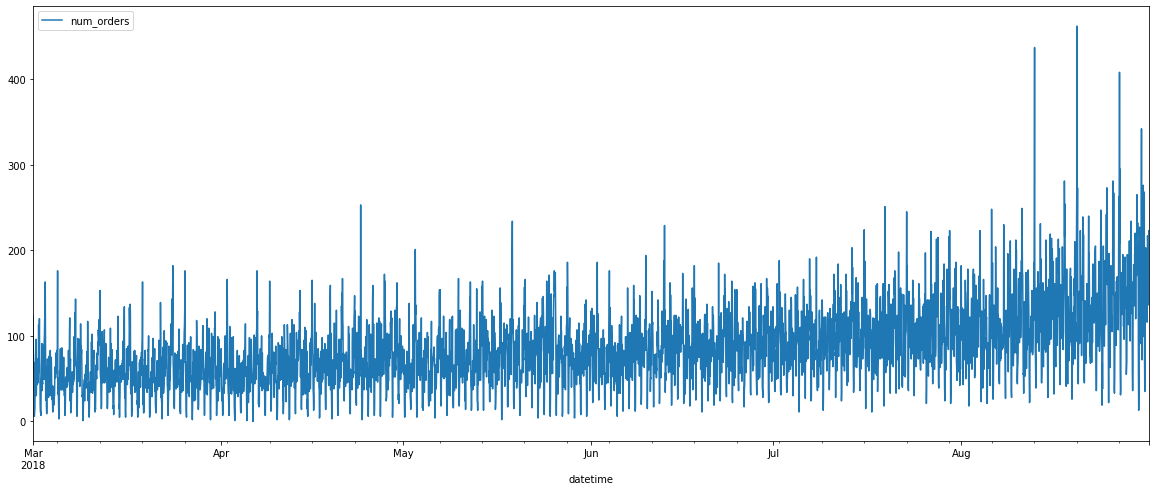

In [5]:
data_taxi = data_taxi .resample('1H').sum()
figsize = (20,8)
data_taxi.plot(figsize=figsize);

### Вывод

Данные загружены и изучены, дополнительной обработки не требуют. Перейдем к анализу

## Анализ

Рассмотрим данные по последней неделе:

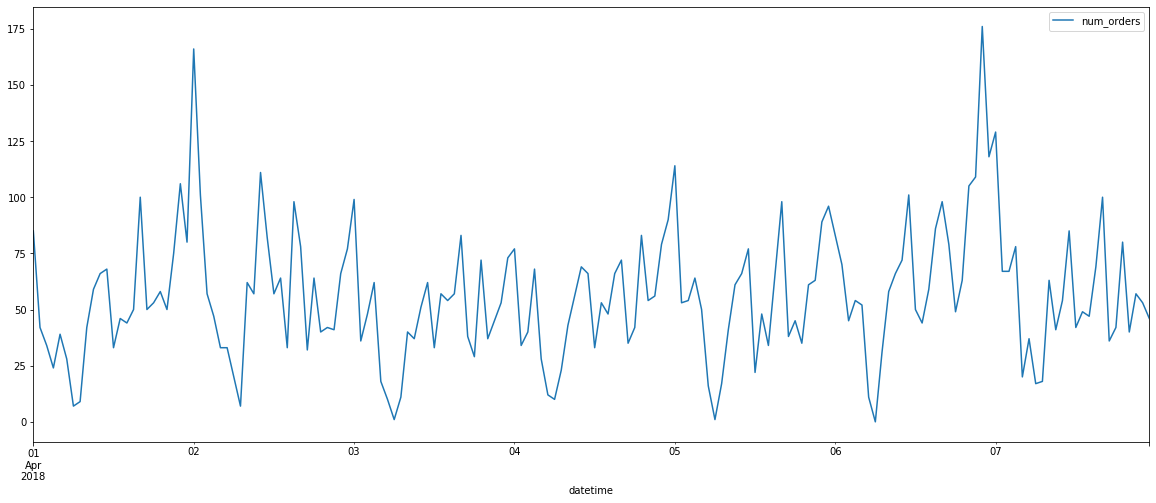

In [6]:
data_taxi['2018-04-01':'2018-04-07'].plot(figsize=figsize);

Разложим временной ряд на тренд и сезонную компоненту:

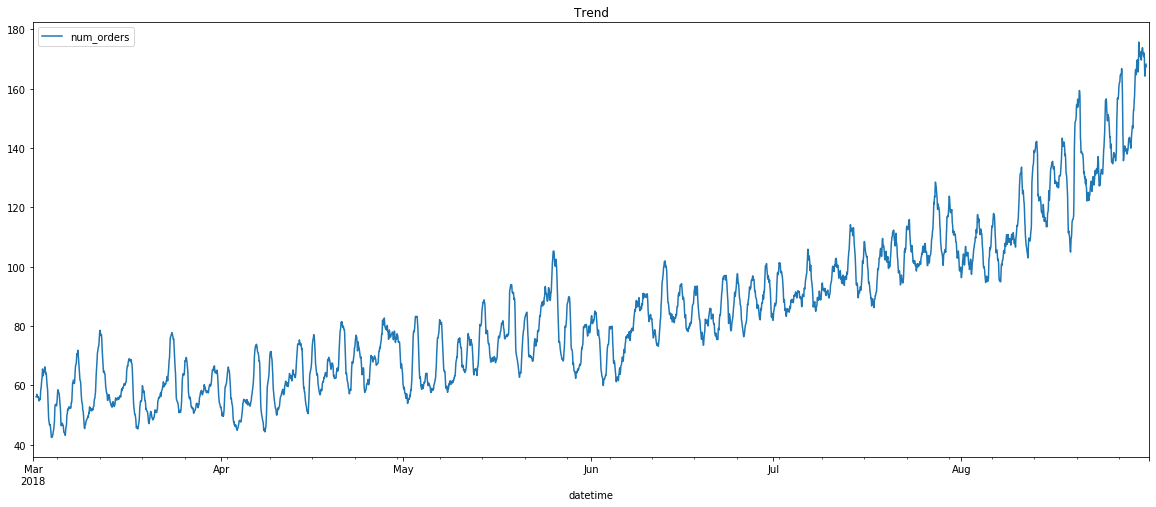

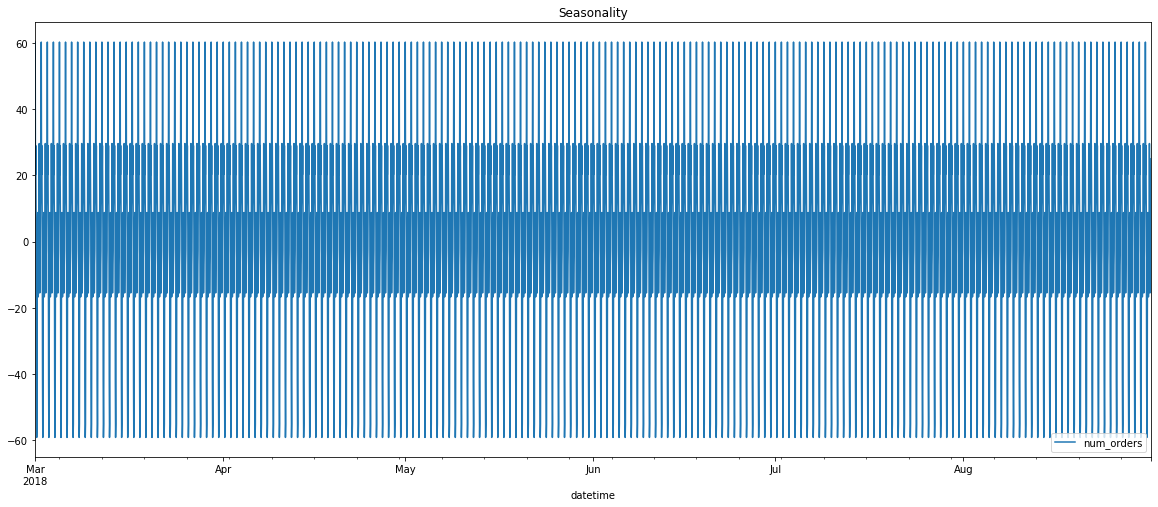

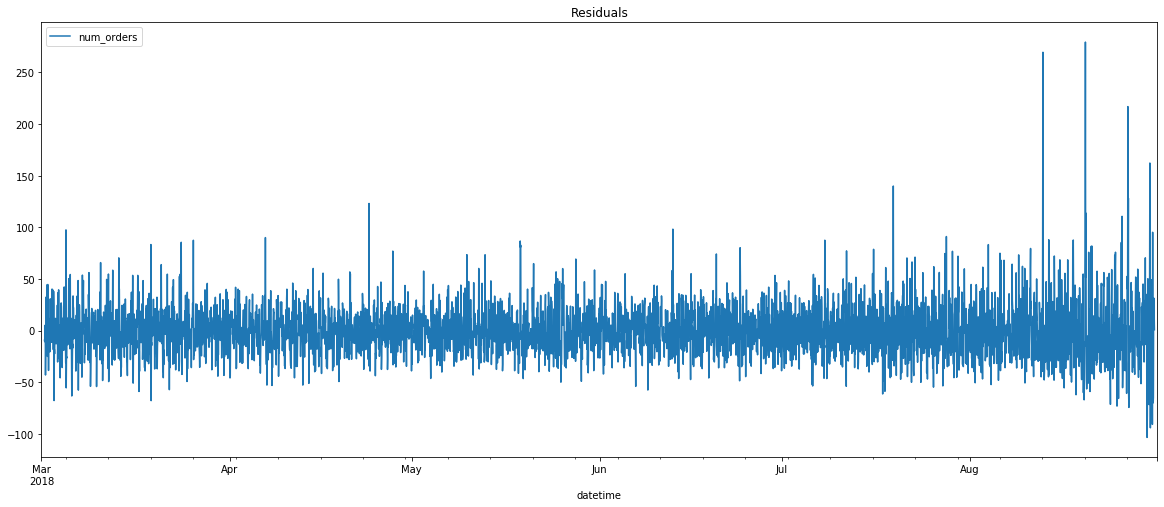

In [7]:
decomposed_data_taxi = seasonal_decompose(data_taxi)

decomposed_data_taxi.trend.plot(figsize=figsize)
plt.title('Trend');

decomposed_data_taxi.seasonal.plot(figsize=figsize)
plt.title('Seasonality');

decomposed_data_taxi.resid.plot(figsize=figsize)
plt.title('Residuals');

Посмотрим аналогичное разделение за последнюю неделю:

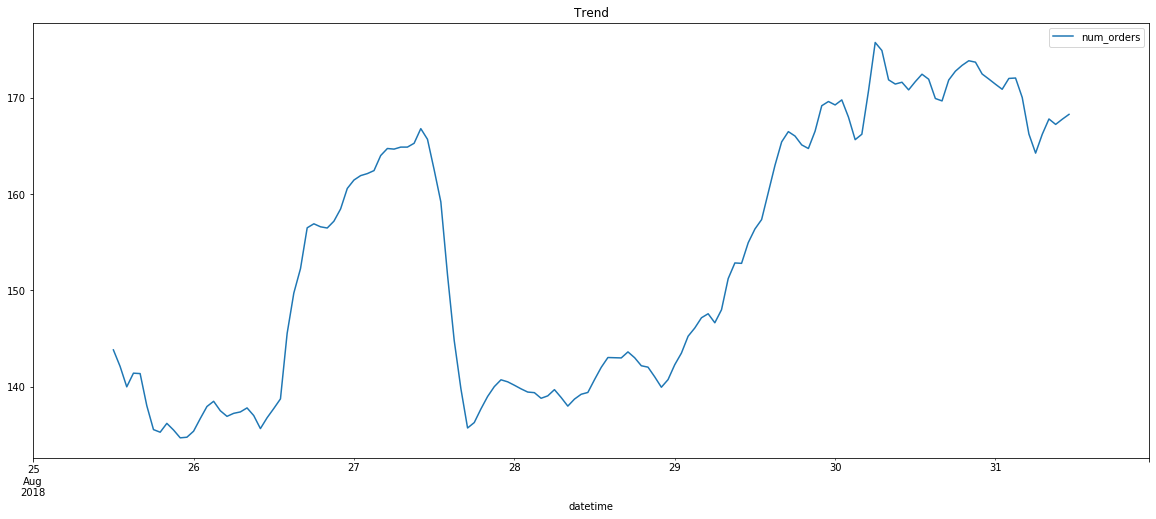

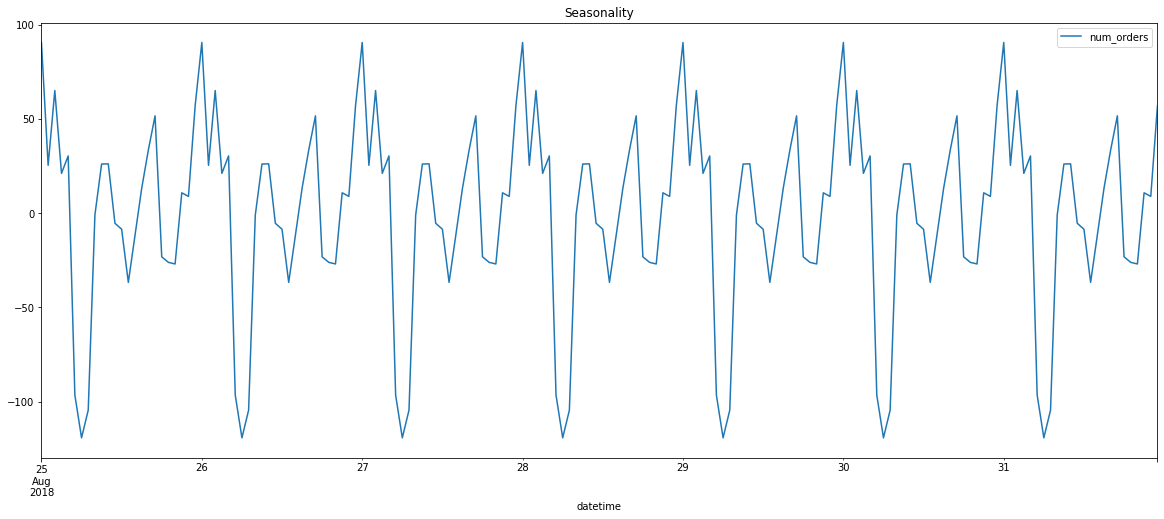

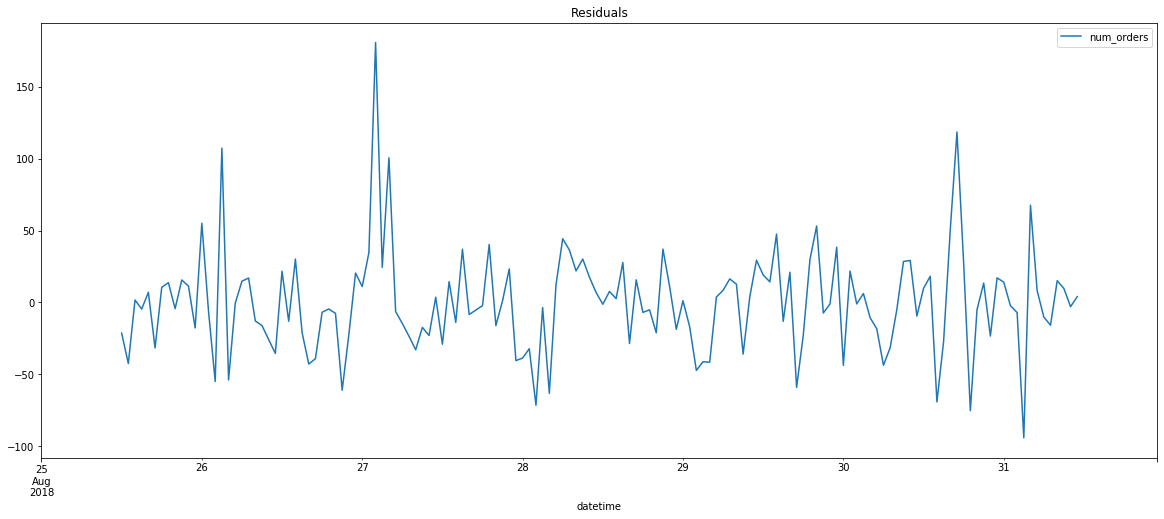

In [8]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])

decomposed_data_taxi.trend.plot(figsize=figsize)
plt.title('Trend');

decomposed_data_taxi.seasonal.plot(figsize=figsize)
plt.title('Seasonality');

decomposed_data_taxi.resid.plot(figsize=figsize)
plt.title('Residuals');

Посмотрим на разделение за последние 3 месяца:

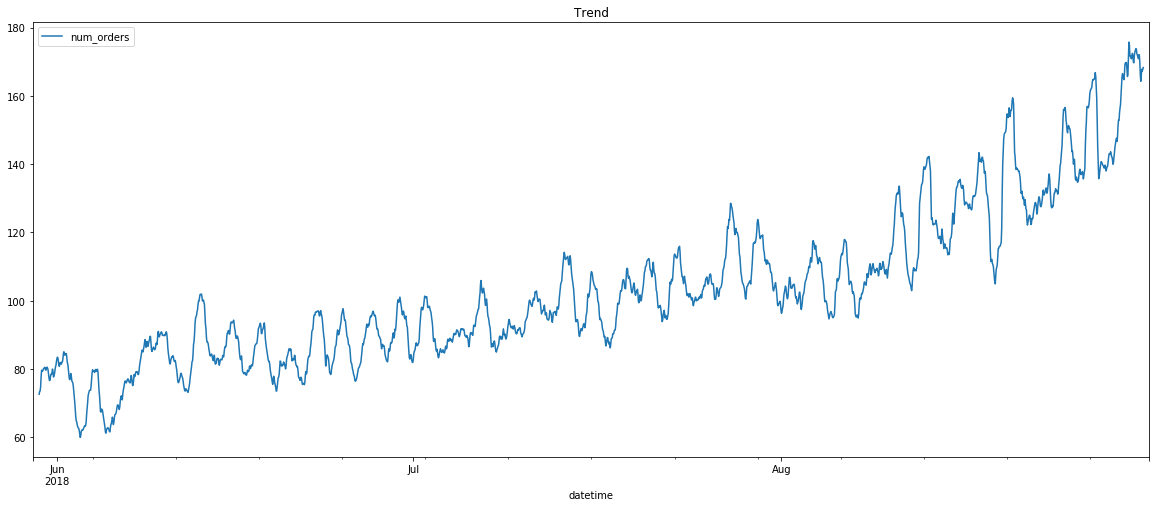

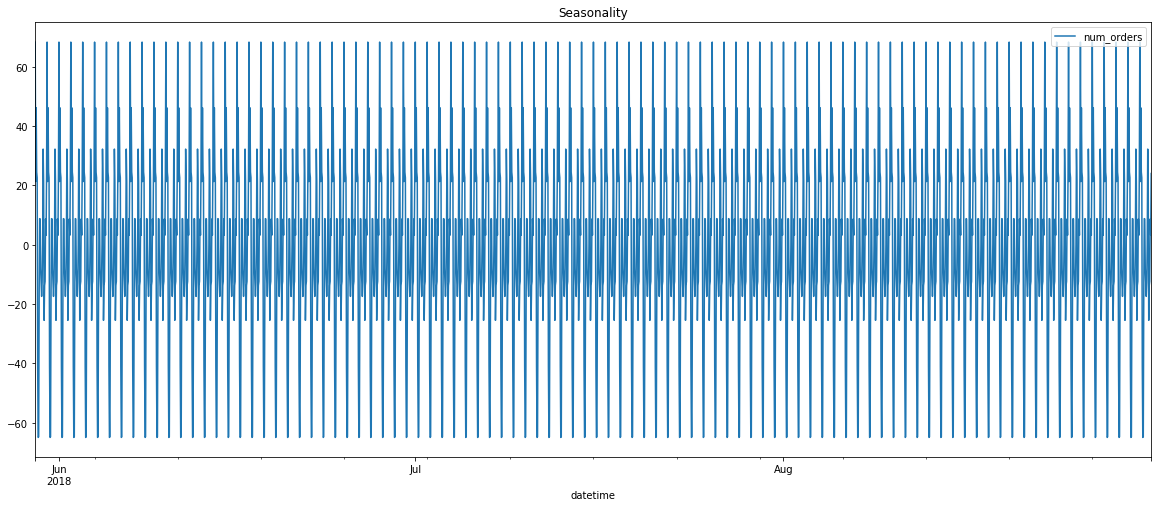

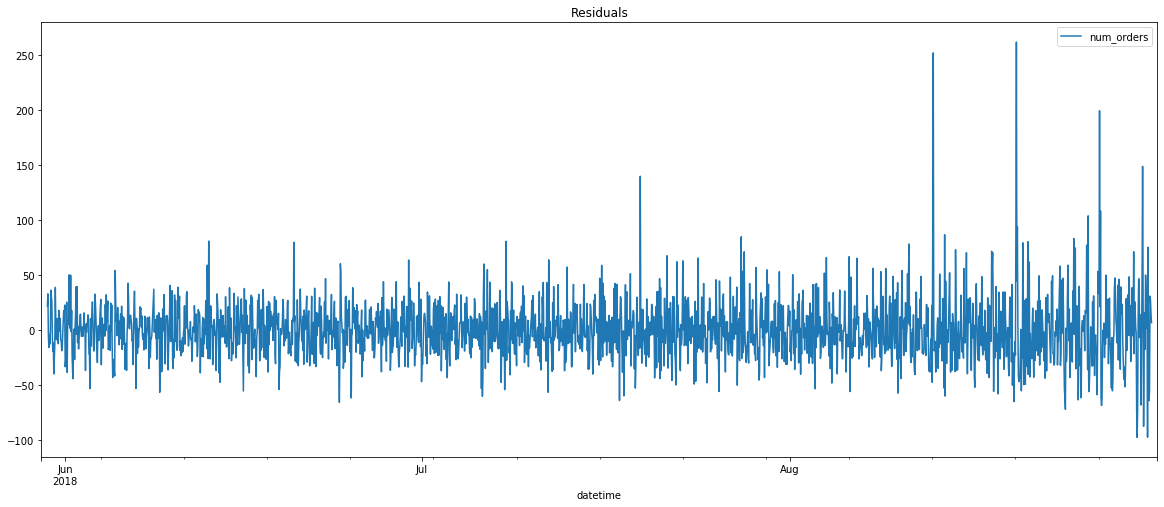

In [9]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-05-30':'2018-08-31'])

decomposed_data_taxi.trend.plot(figsize=figsize)
plt.title('Trend');

decomposed_data_taxi.seasonal.plot(figsize=figsize)
plt.title('Seasonality');

decomposed_data_taxi.resid.plot(figsize=figsize)
plt.title('Residuals');

Дисперсия ряда со временем увеличивается.
По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.
И каждый день видно, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени.

 Посмотрим на распределение данных за последние сутки

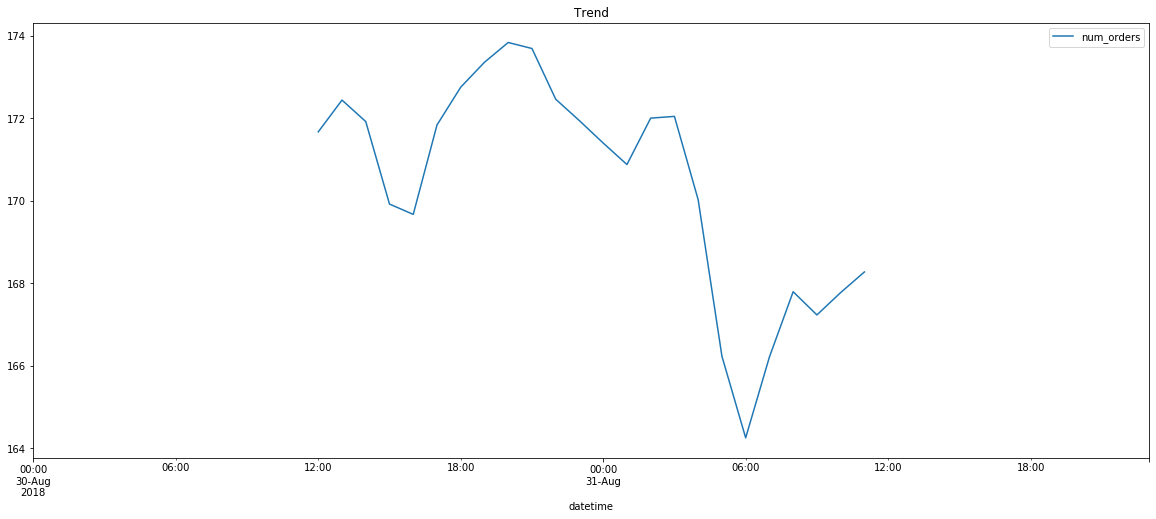

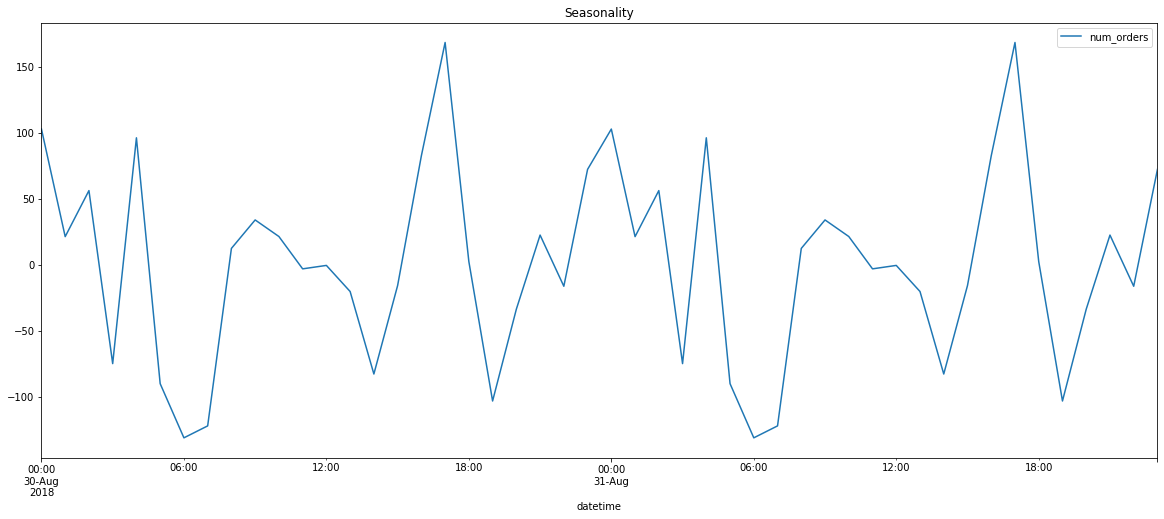

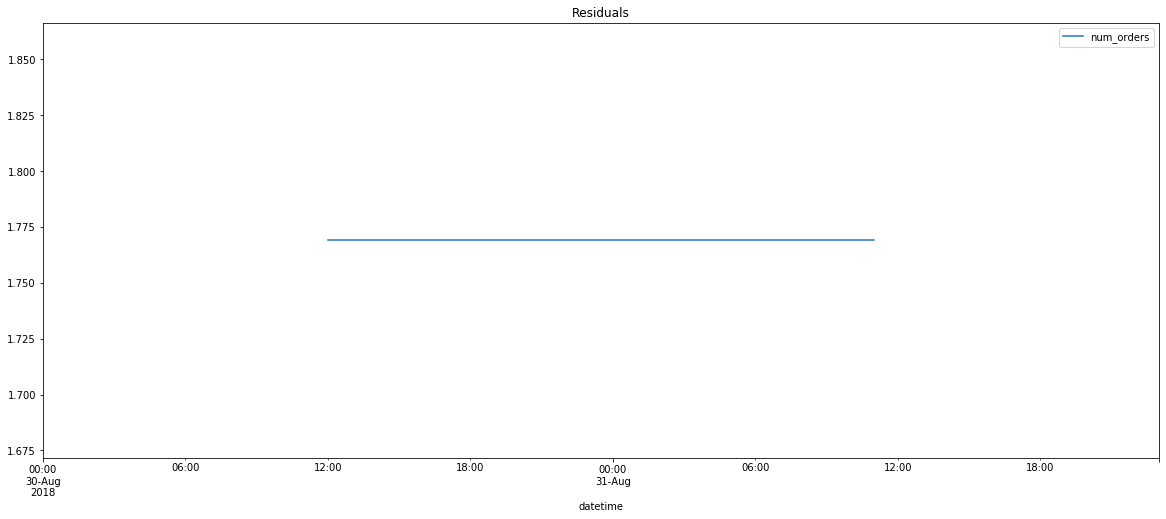

In [18]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-30':'2018-08-31'])

decomposed_data_taxi.trend.plot(figsize=figsize)
plt.title('Trend');

decomposed_data_taxi.seasonal.plot(figsize=figsize)
plt.title('Seasonality');

decomposed_data_taxi.resid.plot(figsize=figsize)
plt.title('Residuals');

Утренний пик по загрузке прихоится на 12 часов, далее небольшой спад и блеже к 17-18 часам нагрузка снова возрастает, после 21 часа вновь заментно постепенное снижение загруженности

Теперь экспериментально подберем размер окна и определим, какое окно в скользящем среднем лучше всего напоминает данные

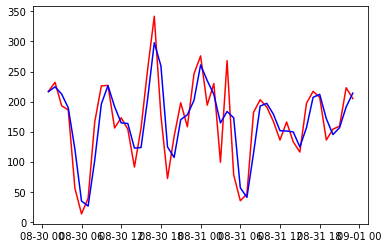

37.20937024517551


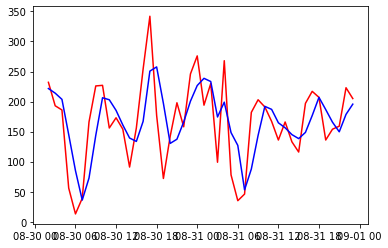

53.29049457074125


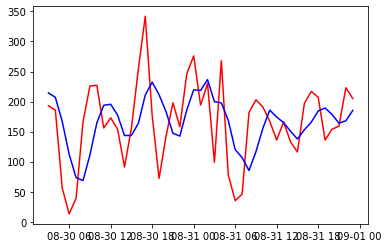

63.744498673306005


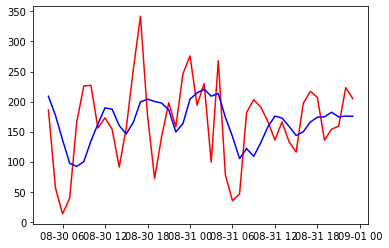

67.59614701230456


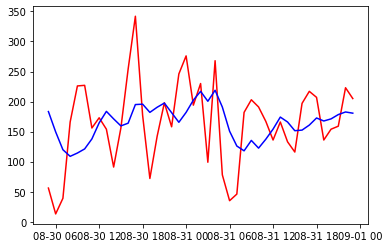

69.73090580801458


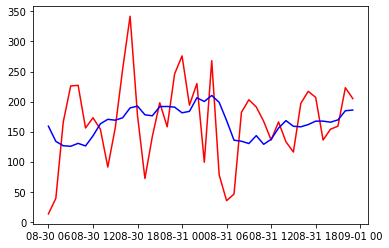

67.92390557450068


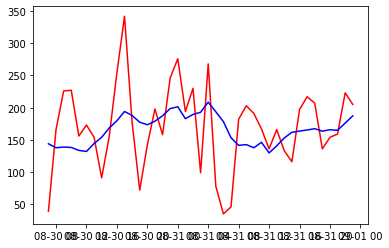

62.926871513977126


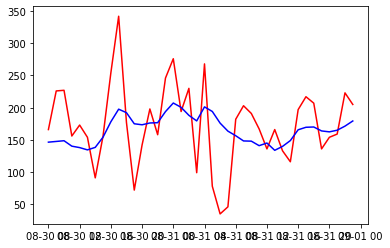

59.28822671627558


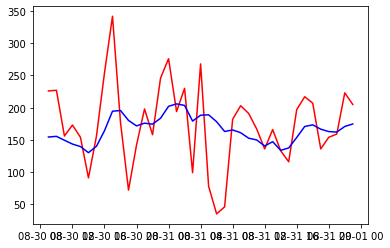

60.03829120033655


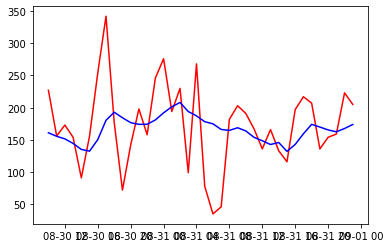

62.14800313100127


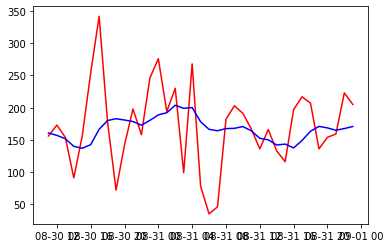

63.27369910554068


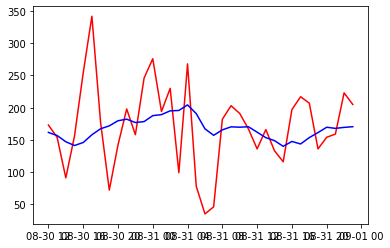

64.5242998632826


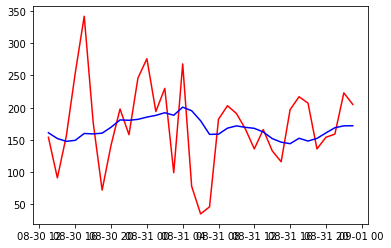

65.5193036785263


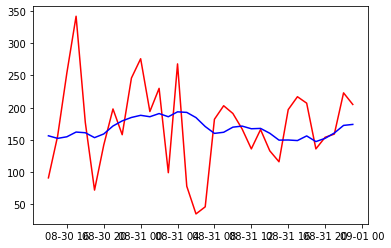

66.57033039492059


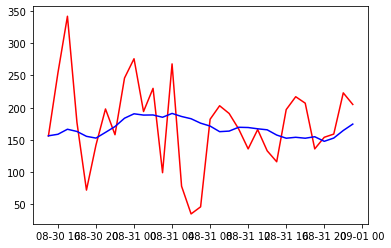

66.3901756391826


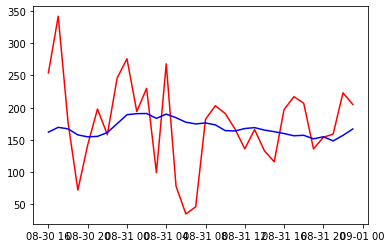

66.786833110948


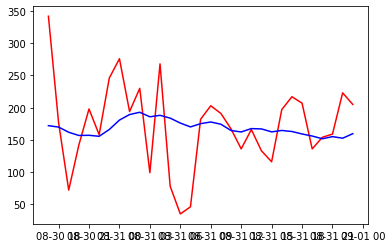

65.9555857159695


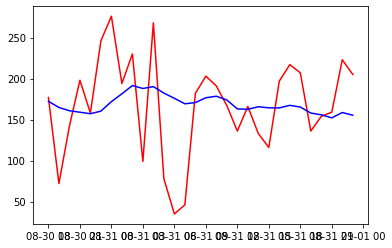

59.95063065843002


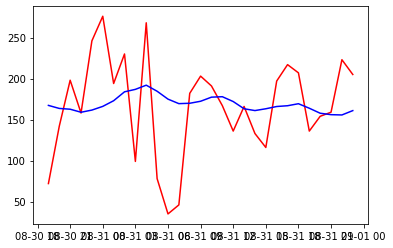

61.62310079608245


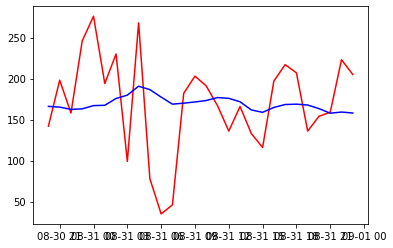

60.295350032185105


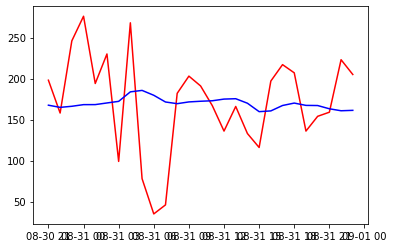

61.584824578009915


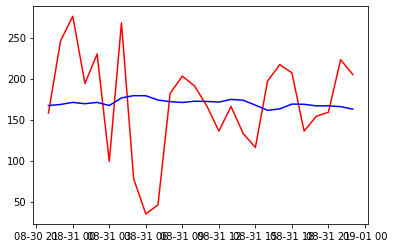

62.2411084136485


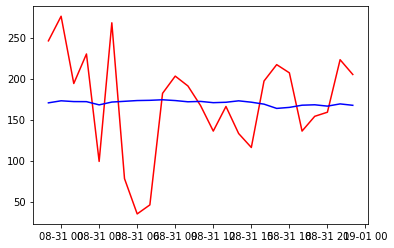

62.204006324173186


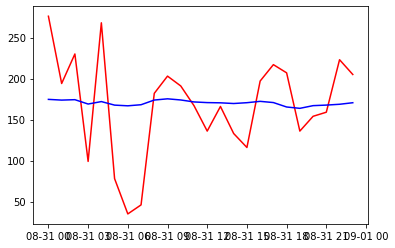

59.35472853951908


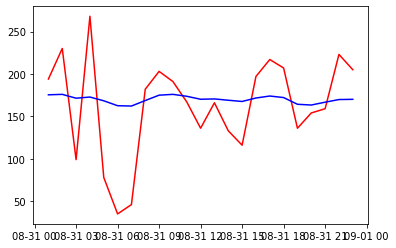

55.395072289503794


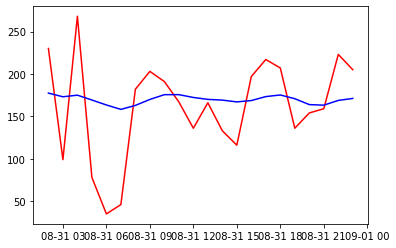

56.59878804647867


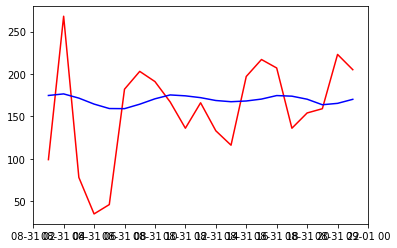

57.99764423770521


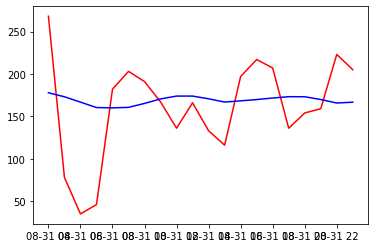

57.88077099016712


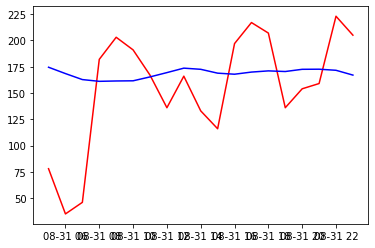

55.952374798698536


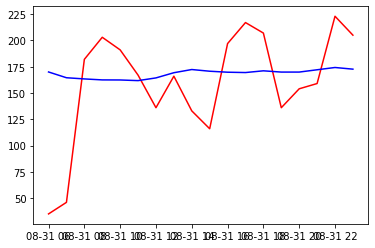

52.57135722880583


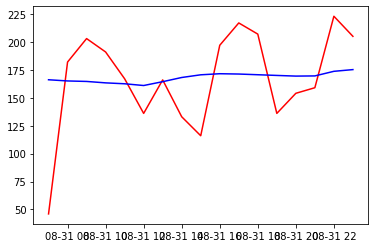

42.49692354782181


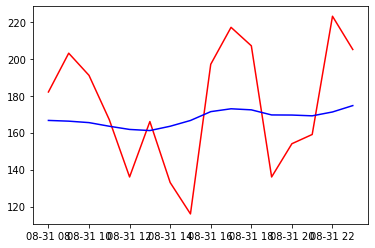

30.931430392629238


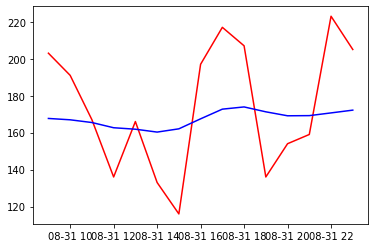

31.350481822389316


In [21]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,35):
    data = data_taxi['2018-08-30':'2018-08-31'].copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    plt.show()
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    print(RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [22]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

Для определения количество lag признаков найдем разницу в часах между максимальным пиком ночью и минимальным пиком в сезонном сегменте

In [23]:
decomposed_data_taxi_24h = seasonal_decompose(data_taxi['2018-08-30':'2018-08-31'])
max_lag = ((decomposed_data_taxi_24h.seasonal.idxmax() - decomposed_data_taxi_24h.seasonal.idxmin()) 
            // np.timedelta64(1, 'h'))[0]
max_lag

11

Создадим функцию make_features для создания признаков для обучения модели:

У нас есть часовая сезонность, поэтому добавим признак hour <br>
Тред показывает, что к концу недели и в середине идет увеличение заказов - добавим признак dayofweek<br>
Добавим аргумент max_lag, который задаст максимальный размер отставания<br>
Вычислим скользящее среднее и добавим его как признак 'rolling_mean'<br>

In [24]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

Разобьем датасет на обучающую и тестовую выборки, сделаем тестовую выборку размером 10% от исходных данных

In [25]:
data_taxi_copy = data_taxi.copy()
make_features(data_taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Создадим cv выборку для временных рядов через TimeSeriesSplit.

In [26]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [28]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 8
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)


31.285773213643168

### Вывод

- Проанализировали данные и вывели тренды и сезонность
- Подготовили данные к обучению: создана функция для определения признаков(day, dayofweek, month, lag, rolling_mean), разбили датасет на обучающую и тестовую выборки в соотношении 9:1
- Создали функцию для кроссвалидации временных рядов

## Обучение

Выберем следующие регрессоры для обучения модели:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

#### LinearRegression

In [29]:
%%time

regressor = LinearRegression()

cv_RMSE_LR = cv_time_series_rmse(regressor=regressor, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('Среднее значение RMSE для LinearRegression равно', round(cv_RMSE_LR, 4))
print()

Среднее значение RMSE для LinearRegression равно 31.2858

CPU times: user 135 ms, sys: 65.7 ms, total: 200 ms
Wall time: 159 ms


#### DecisionTreeRegressor

In [30]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 25)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Лучшие параметры для DecisionTreeRegressor:")
print()

best_params_DTR = clf.best_params_
print(best_params_DTR)
print()

regressor.set_params(**best_params_DTR)

cv_RMSE_DTR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее значение RMSE для DecisionTreeRegressor равно', round(cv_RMSE_DTR, 4))
print()

Лучшие параметры для DecisionTreeRegressor:

{'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}

Среднее значение RMSE для DecisionTreeRegressor равно 29.0215

CPU times: user 2.32 s, sys: 6.35 ms, total: 2.33 s
Wall time: 2.33 s


#### CatBoostRegressor

In [31]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[123456],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Лучшие параметры для CatBoostRegressor:")
print()
best_params_CBR = clf.best_params_
print(best_params_CBR)
print()


regressor.set_params(**best_params_CBR)
cv_RMSE_CBR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Среднее значение RMSE для CatBoostRegressor равно', round(cv_RMSE_CBR, 4))
print()

Лучшие параметры для CatBoostRegressor:

{'learning_rate': 0.1, 'random_state': 123456, 'verbose': False}

Среднее значение RMSE для CatBoostRegressor равно 24.7148

CPU times: user 6min 48s, sys: 58.8 s, total: 7min 46s
Wall time: 8min 26s


#### LGBMRegressor

In [32]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[1234]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Лучшие параметры для LGBMRegressor:")
print()
best_params_LGBMR = clf.best_params_
print(best_params_LGBMR)
print()

regressor.set_params(**best_params_LGBMR)
cv_RMSE_LGBMR = cv_time_series_rmse(regressor=regressor, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Среднее значение RMSE для LGBMRegressor равно', round(cv_RMSE_LGBMR, 4))

Лучшие параметры для LGBMRegressor:

{'learning_rate': 0.1, 'random_state': 1234}

Среднее значение RMSE для LGBMRegressor равно 25.0233
CPU times: user 32.2 s, sys: 0 ns, total: 32.2 s
Wall time: 32.6 s


## Тестирование

#### LinearRegression

RMSE для LinearRegression на тестовой выборке равно 50.7312

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 71.5 ms


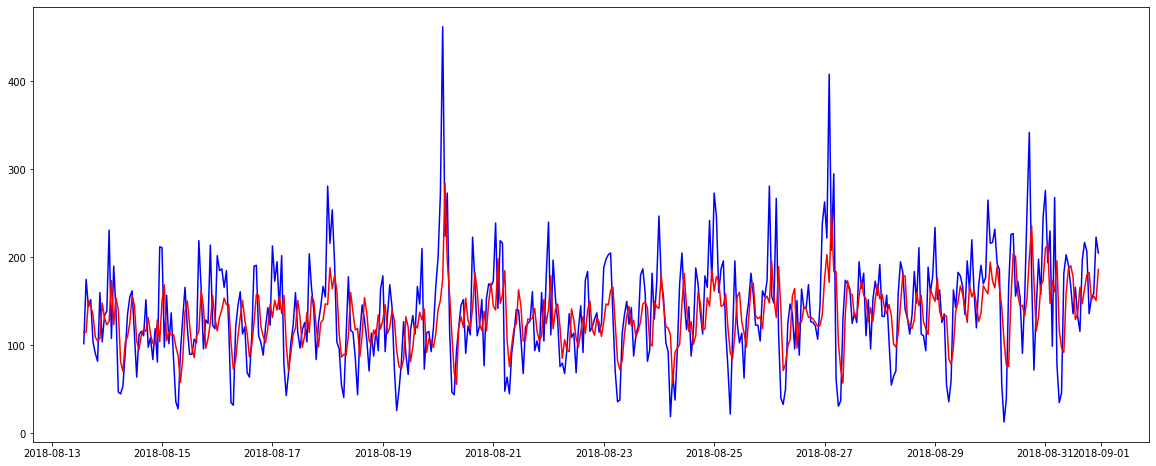

In [33]:
%%time

model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LR = mean_squared_error(test_target, target_predict) ** 0.5

print('RMSE для LinearRegression на тестовой выборке равно', round(final_RMSE_LR, 4))
print()

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### DecisionTreeRegressor

RMSE для DecisionTreeRegressor на тестовой выборке равно 49.9821

CPU times: user 52.3 ms, sys: 0 ns, total: 52.3 ms
Wall time: 49.7 ms


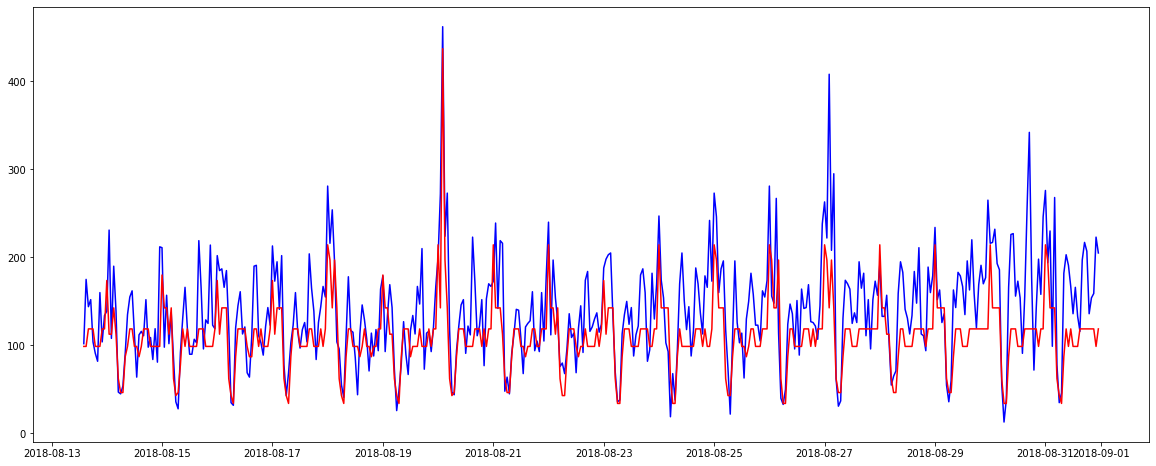

In [34]:
%%time

model = DecisionTreeRegressor()
model.set_params(**best_params_DTR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)

final_RMSE_DTR = mean_squared_error(test_target, target_predict) ** 0.5
print('RMSE для DecisionTreeRegressor на тестовой выборке равно', round(final_RMSE_DTR, 4))
print()

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### CatBoostRegressor

RMSE для CatBoostRegressor на тестовой выборке равно 42.548

CPU times: user 18.7 s, sys: 2.65 s, total: 21.4 s
Wall time: 22.8 s


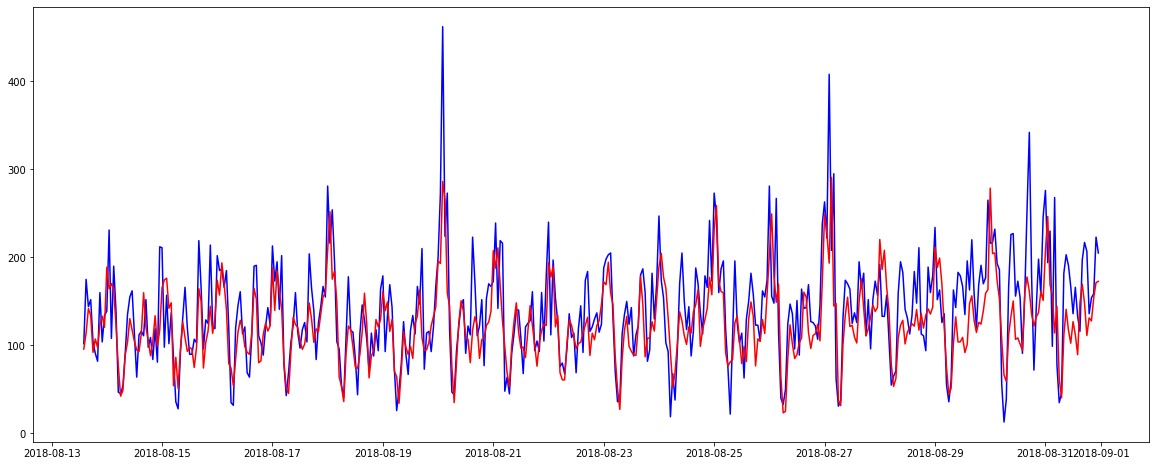

In [35]:
%%time

model = CatBoostRegressor()
model.set_params(**best_params_CBR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)

final_RMSE_CBR = mean_squared_error(test_target, target_predict) ** 0.5
print('RMSE для CatBoostRegressor на тестовой выборке равно', round(final_RMSE_CBR, 4))
print()

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### LGBMRegressor

RMSE для LGBMRegressor на тестовой выборке равно 42.548

CPU times: user 1.23 s, sys: 14.5 ms, total: 1.24 s
Wall time: 1.2 s


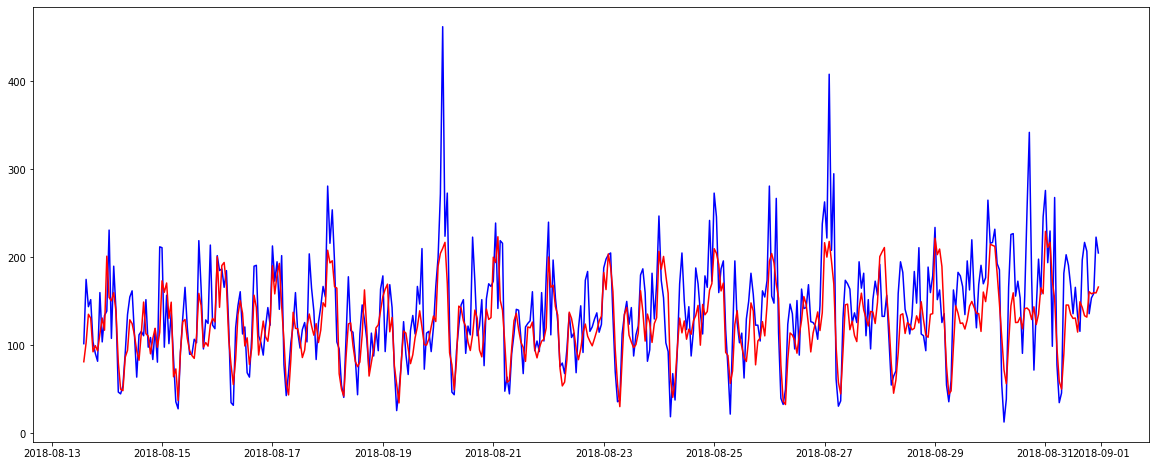

In [36]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBMR = mean_squared_error(test_target, target_predict) ** 0.5
print('RMSE для LGBMRegressor на тестовой выборке равно', round(final_RMSE_CBR, 4))
print()

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

Для удобного сравнения занесем все результаты обучения и анализа моделей в таблицу:

In [37]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'RMSE на CV':[cv_RMSE_LR,
                      cv_RMSE_DTR,
                      cv_RMSE_CBR,
                      cv_RMSE_LGBMR],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                           final_RMSE_DTR,
                                           final_RMSE_CBR,
                                           final_RMSE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,RMSE на CV,RMSE модели на тестовой выборке
LinearRegression,31.285773,50.731198
DecisionTreeRegressor,29.021477,49.982054
CatBoostRegressor,24.714830,42.547953
LGBMRegressor,25.023308,42.533234


## Вывод

1. Проанализировали данные и вывели тренды и сезонность
2. Подготовили данные к обучению: 
    - создали функцию для определения признаков(day, dayofweek, month, lag, rolling_mean)
    - разбили датасет на обучающую и тестовую выборки в соотношении 9:1
    - создали функцию для кроссвалидации временных рядов
3. Провели обчение обучения модели на следующих регрессорах:
    - LinearRegression
    - DecisionTreeRegressor
    - CatBoostRegressor
    - LGBMRegressor
4. Исходя из финальной таблицы лучше всего отработали модели CatBoostRegressor и LGBMRegressor, их значения RMSE на тестовой выборке равны 42.54 и 42.53 соответсвенно